In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append("..")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
from src.utils.plots import plot_kpis
from src.utils.utils import week_of_month
from src.utils.orthogonalization import VariableOrthogonalization
from src.evaluate_model import report_metrics

pd.options.display.float_format = '{:.4f}'.format
sns.set_theme()

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import graphviz as gr

%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

# Problema Case Ifood
> Objetivo: Entender o impacto dos investimentos em mídia nos indicadores de desempenho (tráfego e engajamento do usuário) e fornecer recomendações estratégicas para otimizar o gasto com mídia.


> Desafio: Identificar quais canais de mídia estão impulsionando os KPIs e como otimizar o orçamento de mídia.

## Import data

De acordo com as instruções do case, as colunas do arquivo representam:
- mo­no­to­ni­cid: Iden­ti­fi­ca­dor úni­co para cada re­gis­tro.
- date: Data do re­gis­tro.
- traf­fic: Nú­me­ro de vi­si­tas ao site.
- no­ti­fi­ca­ti­ons­sent: Nú­me­ro de no­ti­fi­ca­ções en­vi­a­das.
- no­ti­fi­ca­ti­ons­clic­ked: Nú­me­ro de no­ti­fi­ca­ções que fo­ram cli­ca­das.
- nac­ti­veu­sers: Nú­me­ro de usuá­ri­os ati­vos.
- event1 e event2: in­di­ca­dor bo­o­le­a­no, re­la­ci­o­na­das ao acon­te­ci­men­to de eventos es­pe­cí­fi­cos.
- Co­lu­nas de in­ves­ti­men­to em mí­dia: cine­ma, digi­tal, in­flu, news­pa­pers, of­fli­ne, ra­dio, so­ci­al, tv, other­me­di­as.
- ho­li­day: In­di­ca­dor se o dia é fe­ri­a­do. 

In [2]:
medias = ["cinema","digital","influ","newpapers","offline","radio","social","tv","other_medias"]
medias_with_more_investment = ["tv", "other_medias", "digital", "offline", "influ", "social"]

In [3]:
from src.prepare_data import load_data, agg_by_week
df = load_data('/Users/marianebando/Documents/Git/projeto_ifood')
df_week = agg_by_week(df)
df_week.head()

,weeks_from_start,date,traffic,...,month,week_of_month,has_media_investment
0,1,2007-01-15,567597,...,2007-01,3,False
1,2,2007-01-22,560370,...,2007-01,4,False
2,3,2007-01-29,568526,...,2007-01,5,False
3,4,2007-02-05,600621,...,2007-02,5,False
4,5,2007-02-12,597438,...,2007-02,3,False


In [4]:
from src.utils.seasonality_effect import get_seasonality
degree = 2
period_year = 52

df_season_year = get_seasonality(df_week["date"], period = period_year, degree = degree)
df_season_year.columns = ["year_" + col for col in df_season_year.columns]
df_week = pd.concat([df_week, df_season_year], axis =1)

# Primeira Análise OLS
Em MMMs, a regressão linear é uma técnica comumente usada para analisar a relação entre variáveis de marketing e a variável resposta. No entanto, a regressão linear assume uma relação linear entre as features e a target, o que nem sempre é verdade, principalmente quando olhamos para investimentos de marketing. Para isso, é importante realizar transformações baseadas na teoria de que o investimento satura após determinado valor.

## Aplicando um carryover simples: decaimento geométrico

In [5]:
from src.utils.carryover_effect import decay_function, ExponentialCarryover
# prior knowledge
half_life_media = {
    "cinema": 3,
    "digital": 2,
    "influ": 1,
    "newpapers": 2,
    "offline": 4,
    "radio": 2,
    "social": 1,
    "tv": 3,
    "other_medias": 1,
}
lag_media = {
    "cinema": 1,
    "digital": 0,
    "influ": 0,
    "newpapers": 1,
    "offline": 2,
    "radio": 1,
    "social": 0,
    "tv": 1,
    "other_medias": 0,
}
# write decay function using half life for each media
decay_media = {m: decay_function(half_life) for m, half_life in half_life_media.items()}

for media in medias:
    carry = ExponentialCarryover(decay_factor = decay_media[media], L = lag_media[media]+1, func = "geo")
    df_week[f"{media}_adstock"] = carry.fit_transform(df_week[media])


## Aplicando uma saturação simples

In [7]:
from src.utils.saturation_effect import SaturationTransformation
for media in medias:
    if df_week[media].max() > 10**6:
        lambda_ = 1/(10**6)
    elif df_week[media].max() > 10**5:
        lambda_ = 1/(10**5)
    else:
        lambda_ = 1/(10**4)
    df_week[f"{media}_sat"] = SaturationTransformation(lambda_ = lambda_, function_curve="exponential").fit_transform(df_week[media+"_adstock"].values.reshape(-1,1))    

In [8]:
df_train, df_test = train_test_split(df_week, test_size = 0.2, random_state = 42, shuffle=False) # shuffle False to keep the order
print(f"Train set from week {int(df_train.index.min())} to {int(df_train.index.max())}")
print(f"Test set from week {int(df_test.index.min())} to {int(df_test.index.max())}")

Train set from week 0 to 52
Test set from week 53 to 66


In [9]:
medias_sat = [media+"_sat" for media in medias_with_more_investment]
formula_medias_str = " + ".join(medias_sat)
formula_medias_str

'tv_sat + other_medias_sat + digital_sat + offline_sat + influ_sat + social_sat'

In [10]:
model = smf.ols(f"traffic ~ n_active_users + notifications_sent + holiday + event1 + event2 + week_of_month + {formula_medias_str}", data = df_train).fit()
linear_pred = model.predict(df_test)
report_metrics(df_test["traffic"], linear_pred)
model.summary()

Metric    Value
--------  ----------
mae       R$ 17.7mil
mape      2.4%
wape      2.4%
r2        50.9%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                traffic   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     14.45
Date:                Fri, 16 Aug 2024   Prob (F-statistic):           7.87e-11
Time:                        13:00:47   Log-Likelihood:                -604.39
No. Observations:                  53   AIC:                             1233.
Df Residuals:                      41   BIC:                             1256.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.367e+05   2.13e+05      1.109      0.274   -1.94e+05    6.68e+05
n_active_users        24.7127     15.254      1.620      0.113      -6.094      55.520
notifications_sent     0.4311      0.197      2.183      0.035       0.032       0.830
holiday             2.035e+04   5833.143      3.488      0.001    8565.368    3.21e+04
event1              6298.0074   1.17e+04      0.536      0.595   -1.74e+04       3e+04
event2             -9.063e-12   7.15e-11     -0.127      0.900   -1.53e-10    1.35e-10
week_of_month      -7851.5356   3573.752     -2.197      0.034   -1.51e+04    -634.196
tv_sat               -73.7958   1.64e+04     -0.005      0.996   -3.31e+04     3.3e+04
other_medias_sat    7.366e+04   3.52e+04      2.091      0.043    2503.221    1.45e+05
digital_sat        -4.333e+04   2.42e+04     -1.790      0.081   -9.22e+04    5556.841
offline_sat         1050.7802   1.83e+04      0.057      0.955    -3.6e+04    3.81e+04
influ_sat           1.837e+04   1.36e+04      1.353      0.183   -9044.171    4.58e+04
social_sat         -1.029e+04   2.52e+04     -0.407      0.686   -6.13e+04    4.07e+04
==============================================================================
Omnibus:                        5.088   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                4.052
Skew:                          -0.633   Prob(JB):                        0.132
Kurtosis:                       3.481   Cond. No.                     3.25e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.96e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Algumas variáveis estão com o P-valor alto, ou seja, elas não são estatisticamente significativa para o modelo.


Um P-valor alto, geralmente acima de um determinado limite (como 0,05), sugere que a variável não contribui de forma significativa para a previsão do valor da variável dependente. 

Essa "fraqueza", normalmente, é devido a uma relação alta entre tal feature e outra. Assim, quatro formas comuns de lidar com esse problema é: 
1. A mais simples: considerar a remoção dessa variável do modelo, pois ela não está fornecendo informações úteis para a previsão.
2. Adicionar interações entre as features correlatas, o que vai indicar que um aumento em uma mídia, acaba interferindo no coeficiente da outra.
3. Usar uma regressão Ridge, que, por conta da regularização L2, ajuda a reduzir a variabilidade causada pela multicolinearidade. 
4. Remover o viés entre variáveis, a partir de uma ortogonalização


In [11]:
cols = ["traffic", "n_active_users", "notifications_sent", "holiday", "event1", "event2"] + medias_sat
corr = df_train[cols].corr()
# remove triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.where(mask)
corr = (corr[(corr > 0.5)&(corr < 1)].dropna(how="all", axis=1).dropna(how="all", axis=0)*100).round(1)
corr

,n_active_users,tv_sat,other_medias_sat,digital_sat,offline_sat,influ_sat
traffic,77.9000,68.8000,76.4000,NaN,NaN,NaN
n_active_users,NaN,70.7000,83.0000,NaN,NaN,NaN
notifications_sent,NaN,NaN,NaN,52.4000,NaN,NaN
tv_sat,NaN,NaN,80.2000,NaN,55.2000,60.9000
other_medias_sat,NaN,NaN,NaN,NaN,55.5000,59.2000
digital_sat,NaN,NaN,NaN,NaN,52.3000,NaN


De fato há uma correlação entre mídias, o que pode explicar esse P-valor baixo

In [12]:
filter_medias = ['tv', 'other_medias', 'digital']
medias_sat = [media+"_sat" for media in filter_medias]
formula_medias_str = " + ".join(medias_sat)
formula_medias_str
model = smf.ols(f"traffic ~ n_active_users + notifications_sent + holiday + event1 + event2 + week_of_month + {formula_medias_str}", data = df_train).fit()
pred_linear_filter = model.predict(df_test)
report_metrics(df_test["traffic"], pred_linear_filter)
model.summary()

Metric    Value
--------  ----------
mae       R$ 16.4mil
mape      2.2%
wape      2.2%
r2        58.0%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                traffic   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     20.15
Date:                Fri, 16 Aug 2024   Prob (F-statistic):           2.25e-12
Time:                        13:02:18   Log-Likelihood:                -605.58
No. Observations:                  53   AIC:                             1229.
Df Residuals:                      44   BIC:                             1247.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.834e+05    1.8e+05      1.578      0.122   -7.85e+04    6.45e+05
n_active_users        20.7797     12.961      1.603      0.116      -5.342      46.901
notifications_sent     0.4402      0.177      2.483      0.017       0.083       0.797
holiday             1.906e+04   5619.766      3.391      0.001    7733.019    3.04e+04
event1              6823.9457   1.16e+04      0.591      0.558   -1.65e+04    3.01e+04
event2              5.474e-12   3.73e-12      1.466      0.150   -2.05e-12     1.3e-11
week_of_month      -7392.0230   3469.196     -2.131      0.039   -1.44e+04    -400.317
tv_sat              6961.4486   1.39e+04      0.501      0.619   -2.11e+04     3.5e+04
other_medias_sat    8.304e+04   3.24e+04      2.566      0.014    1.78e+04    1.48e+05
digital_sat        -4.564e+04   2.05e+04     -2.227      0.031   -8.69e+04   -4343.426
==============================================================================
Omnibus:                        4.927   Durbin-Watson:                   1.266
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                3.992
Skew:                          -0.648   Prob(JB):                        0.136
Kurtosis:                       3.357   Cond. No.                     9.02e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.55e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Adicionando relações entre mídias e número de usuários ativos apenas adicionou mais viés ao modelo, com p-valor dessas relações alto.

In [23]:
medias_with_more_investment = ["tv", "other_medias", "digital", "offline"]
medias_sat = [media+"_sat" for media in medias_with_more_investment]
formula_medias_str = " + ".join(medias_sat)
formula_medias_str += "+ tv_sat * n_active_users + other_medias_sat * n_active_users" 
model = smf.ols(f"traffic ~ n_active_users + notifications_sent + holiday + event1 + event2 + week_of_month + {formula_medias_str}", data = df_train).fit()
pred_linear_filter = model.predict(df_test)
report_metrics(df_test["traffic"], pred_linear_filter)
model.summary()

Metric    Value
--------  ----------
mae       R$ 19.4mil
mape      2.6%
wape      2.7%
r2        43.9%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                traffic   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     13.99
Date:                Fri, 16 Aug 2024   Prob (F-statistic):           1.29e-10
Time:                        13:08:05   Log-Likelihood:                -605.07
No. Observations:                  53   AIC:                             1234.
Df Residuals:                      41   BIC:                             1258.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        2.599e+05    4.1e+05      0.634      0.530   -5.68e+05    1.09e+06
n_active_users                     22.0342     31.199      0.706      0.484     -40.973      85.042
notifications_sent                  0.4512      0.199      2.262      0.029       0.048       0.854
holiday                          1.813e+04   5913.508      3.066      0.004    6186.376    3.01e+04
event1                           7715.3477   1.21e+04      0.638      0.527   -1.67e+04    3.21e+04
event2                           4.518e-10   7.67e-10      0.589      0.559    -1.1e-09       2e-09
week_of_month                   -6201.8187   3815.902     -1.625      0.112   -1.39e+04    1504.551
tv_sat                           4.046e+05   4.56e+05      0.887      0.380   -5.17e+05    1.33e+06
other_medias_sat                -2.495e+05   6.82e+05     -0.366      0.716   -1.63e+06    1.13e+06
digital_sat                     -4.542e+04   2.32e+04     -1.954      0.058   -9.24e+04    1523.193
offline_sat                     -2440.4152   1.93e+04     -0.126      0.900   -4.14e+04    3.66e+04
tv_sat:n_active_users             -28.4270     32.514     -0.874      0.387     -94.091      37.237
other_medias_sat:n_active_users    23.8052     51.022      0.467      0.643     -79.235     126.845
==============================================================================
Omnibus:                        5.979   Durbin-Watson:                   1.221
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                4.906
Skew:                          -0.675   Prob(JB):                       0.0860
Kurtosis:                       3.632   Cond. No.                     8.06e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.2e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Acima é uma tentativa de remover algumas features, mantendo só as 3 principais, mas a correlação entre tv, outras mídias e número de usuários continua atrapalhando o modelo. Vamos tentar agora com uma Ridge

# 2. Ridge

O Ridge Regression é frequentemente preferido à Regressão Linear em casos de multicolinearidade porque ele adiciona um termo de regularização que ajuda a estabilizar as estimativas dos coeficientes, tornando o modelo mais robusto. 


Na Regressão Linear sem regularização, a multicolinearidade pode causar coeficientes instáveis, ou seja, pequenas variações nos dados podem levar a grandes mudanças nos coeficientes estimados. Isso resulta em um modelo sensível ao ruído e com baixa capacidade de generalização.


Ao aplicar a penalidade, o Ridge controla o problema de multicolinearidade, produzindo coeficientes mais estáveis e menos sensíveis ao ruído nos dados. O modelo resultante tende a generalizar melhor para novos dados.

In [33]:
# use normal Ridge regression
from sklearn.linear_model import Ridge
all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"]
ridge_with_no_constraints = Ridge(alpha = 1)
ridge_with_no_constraints.fit(df_train[all_features], df_train["traffic"])
pred_ridge_with_no_constraints = ridge_with_no_constraints.predict(df_test[all_features])
report_metrics(df_test["traffic"], pred_ridge_with_no_constraints)

Metric    Value
--------  ----------
mae       R$ 23.0mil
mape      3.2%
wape      3.1%
r2        40.0%


In [34]:
from src.regression_model import RidgeWithPositiveConstraints, MMMRegression
all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"]
best_params = {"regression__alpha":1}
ridge_model = MMMRegression(medias=medias_with_more_investment, model_type="ridge", positive_features=medias_with_more_investment+["event1", "event2"], all_features = all_features, best_params=best_params)
ridge_model.fit(df_train[all_features], df_train["traffic"])
pred_ridge = ridge_model.predict(df_test[all_features])
ridge_model.score(df_test["traffic"], pred_ridge)

Metric    Value
--------  ----------
mae       R$ 18.3mil
mape      2.5%
wape      2.5%
r2        53.2%


# Retirando viés com Ortogonalização
Uma técnica simples de retirar viés é por meio da ortogonalização, que nada mais é que entender quanto de uma variável explica a outra. Quando há correlação entre elas, é esperado que exista uma parte da feature A que explique B, assim, podemos aplicar uma regressão:
$$\text{Variável A} = \alpha + \beta_1 * \text{Variável B} + \sum_{i}^{n+1} \beta_{i+1} * \text{outras confounders}$$
- Sendo n o total de outras confounders.


Depois de descoberto os coeficientes que explicam essa a variável A, é possível usá-los para prever a própria variável A, dado unicamente as features usadas na regressão. A diferença entre essa predição e o valor real da variável A retorna o que chamamos de **resíduo**, que nada mais é que a variável A sem impacto das outras variáveis

In [17]:
variable_a = "n_active_users"
other_variables = ["n_active_users", "notifications_sent", "holiday", "event1", "event2"]

deort = VariableOrthogonalization(variable_a, confounders=medias_sat+other_variables)
df_train = deort.fit_transform(df_train.reset_index())
df_test = deort.fit_transform(df_test.reset_index())
pd.concat([df_train[[f"{variable_a}", "other_medias_sat"]]], axis = 1).corr().iloc[0]

n_active_users     1.0000
other_medias_sat   0.0000
Name: n_active_users, dtype: float64

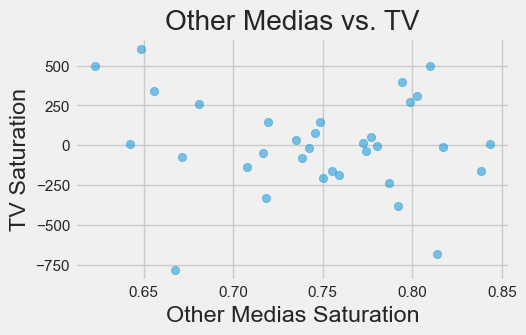

In [18]:
# plot cinema_sat vs. digital_sat
variable_a = "n_active_users"
plt.figure(figsize=(5,3))
base_plot = df_train[df_train['other_medias_sat']>0]
plt.scatter(base_plot["other_medias_sat"], base_plot[variable_a], alpha=0.5)

plt.xlabel("Other Medias Saturation")
plt.ylabel("TV Saturation")
plt.title("Other Medias vs. TV")
plt.show()


In [19]:
# variable_a = ["tv_sat", "other_medias_sat", "digital_sat"]
# other_variables = ["n_active_users", "notifications_sent", "holiday", "event1", "event2"]

# deort = VariableOrthogonalization(variable_a, confounders=medias_sat+other_variables)
# df_train = deort.fit_transform(df_train.reset_index())
# df_test = deort.fit_transform(df_test.reset_index())

In [20]:
medias_res = [
    "digital_sat", 
    "influ_sat", 
    "offline_sat", 
    'social_sat',
    'tv_sat',
    'other_medias_sat'
]
cols = ["traffic", "n_active_users", "notifications_sent", "holiday", "event1", "event2"] + medias_res

corr = df_train[cols].corr()
# remove triângulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.where(mask)
corr = (corr[(corr > 0.5)&(corr < 1)].dropna(how="all", axis=1).dropna(how="all", axis=0)*100).round(1)
corr

,digital_sat,offline_sat,tv_sat,other_medias_sat
traffic,NaN,NaN,68.8000,76.4000
notifications_sent,52.4000,NaN,NaN,NaN
digital_sat,NaN,52.3000,NaN,NaN
influ_sat,NaN,NaN,60.9000,59.2000
offline_sat,NaN,NaN,55.2000,55.5000
tv_sat,NaN,NaN,NaN,80.2000


# Testando a OLS com valores residuais

In [36]:
from src.regression_model import RidgeWithPositiveConstraints, MMMRegression
all_features = medias_with_more_investment + ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"]
best_params = {"regression__alpha":1}
ridge_model = MMMRegression(
    medias=medias_with_more_investment, 
    model_type="ridge", 
    positive_features=medias_with_more_investment+["event1", "event2"], 
    confounders= ["n_active_users","notifications_sent","holiday","event1","event2", "week_of_month"],
    biased_features=["tv", "other_medias", "digital"],
    all_features = all_features, 
    best_params=best_params)
ridge_model.fit(df_train[all_features], df_train["traffic"])
pred_ridge = ridge_model.predict(df_test[all_features])
ridge_model.score(df_test["traffic"], pred_ridge)

Metric    Value
--------  ----------
mae       R$ 19.3mil
mape      2.6%
wape      2.6%
r2        47.5%
